<h1>CS4619: Artificial Intelligence II</h1>
<h1>Word Embeddings</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.initializers import Constant

from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# This OneHot layer comes from https://fdalvi.github.io/blog/2018-04-07-keras-sequential-onehot/

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

def OneHot(input_dim=None, input_length=None):
    # Check if inputs were supplied correctly
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    # Helper method (not inlined for clarity)
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    # Final layer representation as a Lambda layer
    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

<h1>Acknowledgements</h1>
<ul>
    <li>Part of the code comes from chapter 6 of: 
        Fran&ccedil;ois Chollet: <i>Deep Learning with Python</i>,
        Manning Publications, 2018
    </li>
</ul>

<h1>Natural Language Processing</h1>
<ul>
    <li>In the previous lecture, we represented each document as a single vector (bag-of-words).
        <ul>
            <li>This is OK for some applications, e.g. spam filtering.</li>
        </ul>
    </li>
    <li>But for many applications of natural language processing (NLP), we may need to treat documents as
        <em>sequences</em> (lists) of words (and maybe of punctuation symbols also):
        <ul>
            <li>Sentiment analysis, e.g. of movie reviews or tweets;</li>
            <li>Machine translation;</li>
            <li>Image captioning;
            </li>
            <li>Question-answering and chatbots.</li>
        </ul>
    </li>
    <li>There are other applications where each example is a sequence of features too, e.g.:
        <ul>
            <li>processing speech;</li>
            <li>processing genomic data;</li>
            <li>timeseries prediction;</li>
            <li>clickstream prediction</li>
        </ul>
    </li>
</ul>

<h2>Sequences of integers</h2>
<ul>
    <li>Now, each word will be given a unique integer (an index, e.g. "a" might be word number 1, "the" might be
        word number 2, and so on). It is common to restrict to a certain vocabulary, e.g. in the code below, we
        restrict to the most common 1000 words, so the indexes are from 1 to 1000. In real applications, this might be tens-of-thousands or even 100s-of-thosuands of the most common words. If someone uses words that are not within the vocabulary, then either these words are ignored or they are all treated as a special token UNK and hence are all assigned to the same unique integer (e.g. they are all word number 1000).
    </li>
    <li>A document will be a sequence of these integers.
        <ul>
            <li>We may add special symbols to the start and end of the document, also given an index.</li>
        </ul>
    </li>
    <li>If we have a batch of documents, we may prefer them all to be the same length (e.g. <i>maxlen</i> = 200 words).
        In which case, we will need to:
        <ul>
            <li>truncate documents that are longer than 200 words; and</li>
            <li>pad documents that have fewer than 200 words using a separate index, e.g. 0.</li>
        </ul>
    </li>
</ul>

<h2>IMDB Reviews, Again</h2>
<ul>
    <li>Let's read in our small IMDB reviews dataset again and turn it into sequences of integers.</li>
</ul>

In [4]:
df = pd.read_csv("../datasets/dataset_5000_reviews.csv")

In [5]:
# Dataset size
m = len(df)

# We'll keep only the 1000 most common words in the reviews.
vocab_size = 1000

# We'll truncate/pad so that each review has 200 words
maxlen = 200

In [6]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [7]:
# Let's look at the first review
padded_sequences[0]

array([  1,  81, 152,  12,  70,  40,  13,  98,   3, 137,   4, 563,  58,
       273,   8, 203,  35,   1, 554, 135,  70,  11,   6,  22,   2, 123,
        17,   1,  38,  11, 123,  54,  16,   5, 409,  38, 563,  98,   6,
         8,   1, 367, 350,   4,   1, 554,   7,   7,   9,   6, 423,  14,
        12,   6,   1, 346,   5,   1,   9,  20, 558,  32,   4,   1, 117,
        30,   1,  25,   3, 387,  34,   6,  22, 283,  20,   1, 558,   6,
       330,   5, 111,   3,  52,  34, 357,   3,  23, 105, 233, 241,   7,
         7,  10,  56, 129,   1, 281,   4,   1, 123,   6, 664,   5,   1,
       196,  12,   9, 261, 117,  82, 280, 610, 791, 174,  17, 791, 791,
       782, 148, 943, 179,   1,  81, 421,  10, 122, 221,  70,  14,  34,
         9,  13,  10, 424, 129,  10,  13,  17,   9,  18,  14,  10, 274,
        52,  10,   2,  17,   3, 186,   5,   1, 283,   4, 563,  22,  39,
       563,  18,  26,  43,  17,   2, 536,  20, 627,   3,  76, 241,  16,
         9,  67, 665, 731, 103, 683,  78, 664,   5,  63, 509,   

In [8]:
# Let's look at how the indexes relate to words
tokenizer.word_index

{'the': 1,
 'a': 2,
 'and': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'movie': 15,
 'with': 16,
 'for': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'you': 21,
 'not': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'at': 29,
 'all': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'from': 35,
 'who': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'about': 40,
 'her': 41,
 'if': 42,
 'out': 43,
 "it's": 44,
 'has': 45,
 'what': 46,
 'there': 47,
 'some': 48,
 'good': 49,
 'when': 50,
 'very': 51,
 'more': 52,
 'up': 53,
 'no': 54,
 'even': 55,
 'would': 56,
 'time': 57,
 'which': 58,
 'my': 59,
 'she': 60,
 'story': 61,
 'see': 62,
 'their': 63,
 'really': 64,
 'only': 65,
 'had': 66,
 'well': 67,
 'can': 68,
 'were': 69,
 'me': 70,
 'much': 71,
 'been': 72,
 'than': 73,
 'because': 74,
 'we': 75,
 'get': 76,
 'bad': 77,
 'into': 78,
 'do': 79,
 'will': 80,
 'first': 81,
 'other': 82,


In [9]:
# Train/test split
split_point = int(m * 0.8)
dev_X = padded_sequences[:split_point]
test_X = padded_sequences[split_point:] 

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["sentiment"])
dev_y = label_encoder.transform(df["sentiment"][:split_point])
test_y = label_encoder.transform(df["sentiment"][split_point:])

<h1>One-Hot Encoding</h1>
<ul>
    <li>We probably should not use the indexes directly. Why not?</li>
    <li>So we could one-hot encode each word.</li>
    
</ul>

<h2>IMDB</h2>
<ul>
    <li>In our IMDB example, each review will now be represented by a list (of length 200) of binary-valued
        vectors (where
        the dimenion of the vector is 1000. Why?)
    </li>
    <li>Converting from integer indexes to binary vectors can be done in many ways. We will do it using a layer 
        in our network using some code given earlier.
    </li>
    <li>Then we will flatten the input into a single vector (<code>maxlen * vocab_size</code>) and then use
        a few dense layers.
    </li>
</ul>

In [10]:
inputs = Input(shape=(maxlen,))
x = OneHot(input_dim=vocab_size, input_length=maxlen)(inputs)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
one_hot_model = Model(inputs, outputs)

one_hot_model.compile(optimizer=SGD(lr=0.001), loss="binary_crossentropy", metrics=["acc"])

2021-08-18 17:38:16.928017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-18 17:38:16.943133: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc54c7cc010 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-18 17:38:16.943147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:
one_hot_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
lambda (Lambda)              (None, 200, 1000)         0         
_________________________________________________________________
flatten (Flatten)            (None, 200000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                6400032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,400,065
Trainable params: 6,400,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
one_hot_history = one_hot_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25, 
                                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

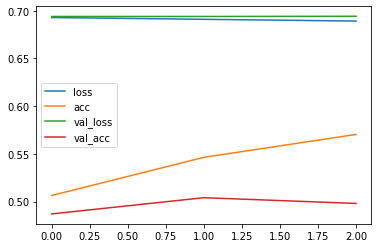

In [13]:
pd.DataFrame(one_hot_history.history).plot()

<ul>
    <li>Not great results but not surprising:
        <ul>
            <li>Small dataset</li>
            <li>One-hot encoding is a poor choice.</li>
        </ul>
    </li>
<ul>

In [14]:
# An illustration of why one-hot encoding is not great.

def cosine_similarity(x, xprime):
    # Assumes x and  xprime are already normalized
    # Converts from sparse matrices because np.dot does not work on them
    return x.dot(xprime.T)

# Word indexes
print("like: ", tokenizer.word_index["like"] )
print("love: ", tokenizer.word_index["love"] )
print("hate: ", tokenizer.word_index["hate"] )

# One hot encodings
one_hot_like = np.zeros(vocab_size)
one_hot_like[ tokenizer.word_index["like"] ] = 1

one_hot_love = np.zeros(vocab_size)
one_hot_love[ tokenizer.word_index["love"] ] = 1

one_hot_hate = np.zeros(vocab_size)
one_hot_hate[ tokenizer.word_index["love"] ] = 1

# Similarities
print("like and love: ", one_hot_like.dot(one_hot_love) )
print("like and hate: ", one_hot_like.dot(one_hot_hate) )

like:  37
love:  120
hate:  818
like and love:  0.0
like and hate:  0.0


<h1>Word Embeddings</h1>
<ul>
    <li>One-hot encoding uses large, sparse vectors.</li>
    <li><b>Word embeddings</b> are small, non-sparse vectors, e.g. the dimension might be 100 or 200.</li>
    <li>To illustrate the ideas, we will use vectors of size 2 (so we can draw 2D diagrams).</li>
    <li>Perhaps we will have the following word embeddings:
        <img src="images/embeddings.png" style="float: right; margin-left: 5em" />
        <ul>
            <li>Dog: $\langle 0.4, 0.3\rangle$</li>
            <li>Hound: $\langle 0.38, 0.32\rangle$</li>
            <li>Wolf: $\langle 0.4, 0.8\rangle$</li>
            <li>Cat: $\langle 0.75, 0.2\rangle$</li>
            <li>Tiger: $\langle 0.75, 0.7\rangle$</li>
        </ul>
    </li>
    <li>The word embeddings we choose should reflect semantic relationships between the words:
        <ul>
            <li>Words with similar meanings should be close together (as with Dog and Hound) and in general
                the distance between embeddings should reflect how closely related the meanings are.
            </li>
            <li>Geometric transformations might encode semantic relationships, e.g.:
                <ul>
                    <li>Adding $\langle 0, 0.5\rangle$ to the word embedding for Dog gives us the word embedding 
                        for Wolf; adding the same vector to the embedding for Cat gives the embedding for Tiger;
                        $\langle 0, 0.5\rangle$ is the "from pet to wild animal" transformation.
                    </li>
                    <li>Similarly $\langle 0.35, -0.1\rangle$ is the "from canine to feline" transformation. Why?
                    </li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<ul>
    <li>There is a Google visiualization here: <a href="https://pair.withgoogle.com/explorables/fill-in-the-blank/">https://pair.withgoogle.com/explorables/fill-in-the-blank/</a></li>
</ul>

<h2>Learning word embeddings</h2>
<ul>
    <li>We learn the word embeddings from the dataset of documents.
    </li>
    <li>Conceptually,
        <ul>
            <li>The values in the vectors are initialized randomly;</li>
            <li>Then they are adjusted during learning.</li>
        </ul>
    </li>
    <li>But Keras does it using a network layer:
        <ul>
            <li>During learning, the weights of the layer are adjusted.</li>
            <li>The activations of the units in the layer are the word embeddings.</li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>

In [15]:
# Throughout the code, we will use 100-dimensional word embeddings (including the pretrained GloVe embeddings later)

embedding_dimension = 100

In [16]:
inputs = Input(shape=(maxlen,))
embedding = Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension)(inputs)
x = Flatten()(embedding)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
embedding_model = Model(inputs, outputs)

embedding_model.compile(optimizer=SGD(lr=0.001), loss="binary_crossentropy", metrics=["acc"])

In [17]:
embedding_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          100000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 740,065
Trainable params: 740,065
Non-trainable params: 0
_________________________________________________________________


In [18]:
embedding_history = embedding_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25, 
                                        callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

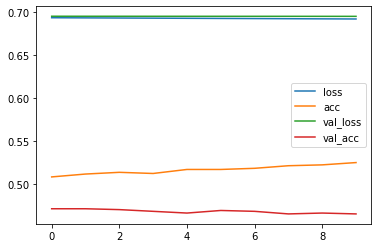

In [19]:
pd.DataFrame(embedding_history.history).plot()

<ul>
    <li>Possibly worse in this case! Perhaps because so little training data.</li>
</ul>

<h2>Pretrained Word Embeddings</h2>
<ul>
    <li>Above, we got our neural network to learn the word embeddings.
        <ul>
            <li>Advantage: they are based on our IMDB data and therefore tailored to 
                helping us to predict the sentiment of restaurant reviews.
            </li>
            <li>Disadvantage: the IMDB dataset (and especially the subset that we are using) is probably too 
                small to learn really powerful
                word embeddings.
            </li>
        </ul>
    </li>
    <li>To some extent, word embeddings are fairly generic, so it can make sense to reuse 
        pretrained embeddings from very large datasets, as we did with image data.
        <ul>
            <li><i>word2vec</i> (<a href="https://code.google.com/archive/p/word2vec/">https://code.google.com/archive/p/word2vec/</a>): 
                This is Google's famous algorithm for learning word embeddings. The URL contains
                code and also pretrained embeddings learned from news articles.
            </li>
            <li><i>GloVe</i> (Global Vectors for Word Representation,
                <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a>):
                This is a Stanford University algorithm. The URL has code and pretrained
                embeddings learned from Wikipedia.
            </li>
        </ul>
    </li>
    <li>Although we'll use GloVe, let's briefly explain how Google learns its <i>word2vec</i> word embeddings:
        <ul>
            <li>It takes a large body of text (e.g. Wikipedia) and builds a model (a two-layer neural network
                classifier) that predicts words.
            </li>
            <li>E.g. in what is known as <i>CBOW (continuous bag-of-words)</i>, it predicts the current word from
                a window of surrounding words.
            </li>
            <li>Or e.g. in what is know as <i>continuous skip-gram</i>, it predicts the surrounding words from
                the current word.
            </li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>
<ul>
    <li>To run the code that follows, you need to download and unzip the file called
        <code>glove.6B.zip</code> (&gt;800MB) from the URL above; save space by deleting all files except
        <code>glove.6B.100d.txt</code> (it's still &gt;300MB)
    </li>
    <li>The code comes from Chollet's book &mdash; details are not important in CS4619</li>
</ul>

In [20]:
# Parse the GloVe word embeddings file: produces a dictionary from words to their vectors

path = "../datasets/glove.6B.100d.txt" # Edit this to point to your copy of the file

embeddings_index = {}
f = open(path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

In [21]:
# Create a matrix that associates the words that we obtained from the IMDB reviews earlier 
# (in the word_index) with their GloVe word embeddings

embedding_matrix = np.zeros((vocab_size, embedding_dimension)) 
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        word_embedding = embeddings_index.get(word)
        if word_embedding is not None:
            embedding_matrix[i] = word_embedding

In [22]:
# Let's take a look at some of the embeddings
glove_like = embedding_matrix[ tokenizer.word_index["like"] ]
glove_love = embedding_matrix[ tokenizer.word_index["love"] ]
glove_hate = embedding_matrix[ tokenizer.word_index["hate"] ]

print("like: ", glove_like)

# Similarities
print("like and love: ", glove_like.dot(glove_love) )
print("like and hate: ", glove_like.dot(glove_hate) )

like:  [-0.2687      0.81708002  0.69896001 -0.72341001  0.091566    0.19557001
 -0.52112001 -0.24313    -0.44701001 -0.27039    -0.34125999 -0.46898001
  0.42583001  0.46289     0.17106    -0.26795     0.23162     0.46568
 -0.31808001  0.75875002  0.31856999  0.64124     0.067042   -0.18516999
  0.49996001  0.36963999 -0.31172001 -0.73097998 -0.26901999 -0.32058001
  0.23394001  0.24276     0.1426     -0.2793      0.38823     0.42398
  0.1021      0.33316001  0.30149999 -0.52710998 -0.024475   -0.15301
 -0.3224     -0.51231003 -0.55250001  0.29819     0.10847     0.052334
 -0.2298     -0.77889001 -0.08928     0.48109001  0.015368    0.92544001
 -0.26122001 -2.47589993 -0.019825    0.58280998  1.30599999  0.73512
 -0.34371999  1.58290005 -0.10814     0.11388     0.79220003  0.18347
  1.22319996  0.35697001  0.17504001 -0.16527    -0.012827   -0.47918001
 -0.32111001 -0.40573001 -0.37151     0.086323    0.25172001 -0.082751
 -0.25584    -0.19178     1.0474     -0.51984    -0.71463001  0

In [23]:
# A similar neural network to earlier but this time the embedding layer's weights come from GloVe and are
# not adjusted during training
inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension,
              embeddings_initializer=Constant(embedding_matrix), trainable=False)(inputs)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
pretrained_embedding_model = Model(inputs, outputs)

pretrained_embedding_model.compile(optimizer=SGD(lr=0.001), loss="binary_crossentropy", metrics=["acc"])

In [24]:
pretrained_history = pretrained_embedding_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25, 
                                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

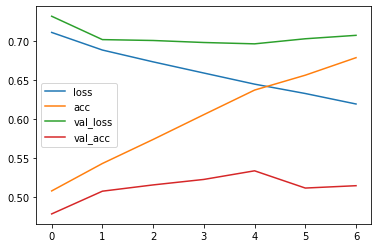

In [25]:
pd.DataFrame(pretrained_history.history).plot()